In [165]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import pandas as pd
from dataclasses import dataclass
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
import eli5
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

import numpy as np
import itertools


In [20]:

df = pd.DataFrame.dropna(pd.read_csv('../annotations/annotated.csv'))
text = df['textlabel']
labels = df['sentiment']

In [37]:
{"Rows": len(df), "Balance": round(df['sentiment'].value_counts(normalize=True), 2)}

{'Rows': 158,
 'Balance': sentiment
 irrelevant    0.61
 relevant      0.39
 Name: proportion, dtype: float64}

Encode the data labels

In [38]:
label_encoder = LabelEncoder()
labels_enc = label_encoder.fit_transform(labels)

Split into training and testing data

In [113]:
X_train, X_test, y_train, y_test = train_test_split(text, labels_enc, test_size=0.20)
print("Train:", np.unique(y_train, return_counts=True), "Test:", np.unique(y_test, return_counts=True)) 

Train: (array([0, 1]), array([74, 52])) Test: (array([0, 1]), array([22, 10]))


Create the pipelines for comparison.

In [157]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
pipelines = []
models = [LogisticRegression(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier()]
vectorizers = [ CountVectorizer(lowercase=True,stop_words=stopwords, ngram_range=(1,2)), TfidfVectorizer(lowercase=True, stop_words=stopwords, ngram_range=(1,2))]

for model, vectorizer in itertools.product(models, vectorizers):
    pipeline = Pipeline([(vectorizer.__class__.__name__, vectorizer), (model.__class__.__name__, model)])
    pipelines.append({
        "combination_name": pipeline.steps[1][0] + ' ' + pipeline.steps[0][0], 
        "vectorizer": pipeline.steps[0][0],
        "model": pipeline.steps[1][0],
        "pipeline": pipeline,
        })

Our data is imbalanced and we prioritise relevant articles since it's better that irrelevant articles are mislabelled than missing out on relevant information.

In [161]:
stats = []
for model in pipelines:
    cross_val = cross_val_score(model['pipeline'],X_train, y_train, scoring="recall")
    mean, std = cross_val.mean(), cross_val.std()
    stats.append(pd.DataFrame({"mean": mean, "variance": std}, index=[model['combination_name']]))    


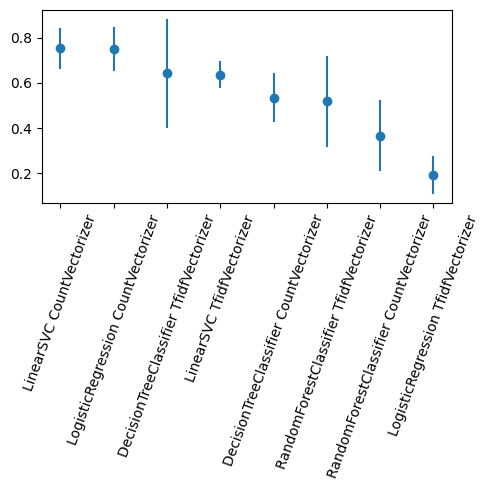

In [162]:
stats_df = pd.concat(stats)
stats_df = stats_df.sort_values(by=stats_df.columns.to_list(), ascending=False)
fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
ax.errorbar(stats_df.index, stats_df['mean'], stats_df['variance'], linestyle='None', marker='o')
ax.tick_params(axis='x', rotation=70)

In [191]:
stats2 = []
for model in pipelines:
    scores = cross_validate(model['pipeline'],X_train, y_train, scoring=["precision", "recall", "f1", "accuracy"])
    summary = {
        "accuracy_avg": np.mean(scores["test_accuracy"]),
        "f1_avg": np.mean(scores["test_f1"]),
        "precision_avg": np.mean(scores["test_precision"]),
        "recall_avg": np.mean(scores["test_recall"]),
    }

    stats2.append(pd.DataFrame(summary, index=[model['combination_name']]))    

stats_df2 = pd.concat(stats2)

We're looking for highest recall with good f1 and precision:

In [193]:
stats_df2

,accuracy_avg,f1_avg,precision_avg,recall_avg
LogisticRegression CountVectorizer,0.793231,0.750901,0.757778,0.750909
LogisticRegression TfidfVectorizer,0.634462,0.295704,0.750000,0.190909
LinearSVC CountVectorizer,0.770154,0.731594,0.716410,0.752727
LinearSVC TfidfVectorizer,0.753538,0.682959,0.765974,0.636364
DecisionTreeClassifier CountVectorizer,0.643077,0.550446,0.601472,0.516364
DecisionTreeClassifier TfidfVectorizer,0.675077,0.640585,0.591111,0.716364
RandomForestClassifier CountVectorizer,0.698154,0.506457,0.769524,0.385455
RandomForestClassifier TfidfVectorizer,0.689231,0.537714,0.668889,0.458182


In [195]:
stopwords = stopwords.words('english')

best_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(lowercase=True, stop_words=stopwords, ngram_range=(1,2))),
    ("classifier", LogisticRegression())
])

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        22
           1       0.88      0.70      0.78        10

    accuracy                           0.88        32
   macro avg       0.88      0.83      0.85        32
weighted avg       0.88      0.88      0.87        32



TFIDF gets a slightly lower score than bag of words because it downgrades frequent words like 'attack' whereas BOW takes the frequency of the words. What's interesting is how much more stable TFIDF is than BOW.

In [13]:

result_c = []
for item in pipelines:
    name = item.get('name')
    pipe = item.get('pipe')
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    report = classification_report(y_test, pred, output_dict=True)
    
    result_c.append({
            "pipeline": name,
            "accuracy": accuracy,
            "report": report,

        })

    


r =pd.DataFrame([{
    "Pipeline": r['pipeline'],
    'f1_0': r['report']['0']['f1-score'],
    'f1_01': r['report']['1']['f1-score'],
    "Macro_F1": r["report"]["macro avg"]["f1-score"],
    "Weighted_F1": r["report"]["weighted avg"]["f1-score"],
    "Accuracy": r["accuracy"]


} for r in result_c])

In [14]:
r.columns.to_list()
r.sort_values(by=r.columns.to_list()[1:-1], ascending=False)

,Pipeline,f1_0,f1_01,Macro_F1,Weighted_F1,Accuracy
0,"BagOfWords, Logistic Regression",0.871795,0.800000,0.835897,0.844872,0.84375
2,"BagOfWords, Support Vector Machines",0.871795,0.800000,0.835897,0.844872,0.84375
5,"TFIDF, Decision Trees",0.871795,0.800000,0.835897,0.844872,0.84375
7,"TFIDF, Random Forest Classifier",0.850000,0.750000,0.800000,0.812500,0.81250
6,"BagOfWords, Random Forest Classifier",0.837209,0.666667,0.751938,0.773256,0.78125
3,"TFIDF, Support Vector Machines",0.820513,0.720000,0.770256,0.782821,0.78125
1,"TFIDF, Logistic Regression",0.791667,0.375000,0.583333,0.635417,0.68750
4,"BagOfWords, Decision Trees",0.702703,0.592593,0.647648,0.661411,0.65625
